In [44]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

In [84]:
# Used imports -- standard imports
import pandas as pd
import cbsodata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time 

Reading all the cbs data

In [46]:
# Converteer naar een Pandas DataFrame voor gemakkelijke manipulatie
df_algemeen = pd.DataFrame(cbsodata.get_data('83765NED'))

# Converteer naar een Pandas DataFrame voor gemakkelijke manipulatie
df_afstanden = pd.DataFrame(cbsodata.get_data('80305ned'))

# Converteer naar een Pandas DataFrame voor gemakkelijke manipulatie
df_gezondheidsmonitor = pd.DataFrame(cbsodata.get_data('85012NED'))

Gereed maken df_algemeen

In [47]:
df_algemeen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16667 entries, 0 to 16666
Columns: 110 entries, ID to GeweldsEnSeksueleMisdrijven_108
dtypes: float64(65), int64(39), object(6)
memory usage: 14.0+ MB


In [48]:
# Checking for possible values
for col in df_algemeen.columns:
    try:
        print('{} : {}'.format(col,df_algemeen[col].unique()))
    except:
        print(col)

ID : [    0     1     2 ... 16664 16665 16666]
WijkenEnBuurten : ['Nederland' 'Aa en Hunze' 'Wijk 00 Annen' ...
 'Wijk 52 Soestweteringlanden' 'Windesheim' 'Harculo en Hoogzutmen']
Gemeentenaam_1 : ['Nederland                               '
 'Aa en Hunze                             '
 'Aalburg                                 '
 'Aalsmeer                                '
 'Aalten                                  '
 'Achtkarspelen                           '
 'Alblasserdam                            '
 'Albrandswaard                           '
 'Alkmaar                                 '
 'Almelo                                  '
 'Almere                                  '
 'Alphen aan den Rijn                     '
 'Alphen-Chaam                            '
 'Ameland                                 '
 'Amersfoort                              '
 'Amstelveen                              '
 'Amsterdam                               '
 'Apeldoorn                               '
 'Appinged

In [49]:
# Remove trailing spaces from column values
df_algemeen = df_algemeen.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Select only Gemeente specific data
df_algemeen = df_algemeen[(df_algemeen['SoortRegio_2'] == 'Gemeente')]

# Rename columns
df_algemeen.rename(columns={'Gemeentenaam_1': 'Gemeente'}, inplace=True)

# Dropping useless columns
df_algemeen.drop(columns=['ID', 'WijkenEnBuurten', 'SoortRegio_2', 'Codering_3', 'IndelingswijzigingWijkenEnBuurten_4', 'MeestVoorkomendePostcode_102'], inplace=True)

In [50]:
df_algemeen

,Gemeente,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,k_15Tot25Jaar_9,k_25Tot45Jaar_10,k_45Tot65Jaar_11,k_65JaarOfOuder_12,Ongehuwd_13,...,ScholenBinnen3Km_98,OppervlakteTotaal_99,OppervlakteLand_100,OppervlakteWater_101,Dekkingspercentage_103,MateVanStedelijkheid_104,Omgevingsadressendichtheid_105,TotaalDiefstalUitWoningSchuurED_106,VernielingMisdrijfTegenOpenbareOrde_107,GeweldsEnSeksueleMisdrijven_108
1,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,1.8,27887,27625,262,NaN,5.0,279.0,2.0,3.0,2.0
77,Aalburg,13067,6615,6452,2527,1760,3006,3584,2190,5639,...,2.5,5317,5041,276,NaN,5.0,376.0,1.0,2.0,3.0
100,Aalsmeer,31373,15516,15857,5866,3484,7221,9089,5713,14718,...,4.4,3229,2013,1216,NaN,4.0,904.0,3.0,3.0,4.0
113,Aalten,27047,13625,13422,4459,2963,5641,8259,5725,12044,...,4.6,9705,9654,52,NaN,4.0,782.0,2.0,2.0,2.0
147,Achtkarspelen,27893,14185,13708,5112,3284,6404,7891,5202,12565,...,3.5,10398,10226,172,NaN,5.0,426.0,1.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16374,Zundert,21657,11121,10536,2903,2589,4663,6995,4507,9488,...,2.2,12121,12070,51,NaN,4.0,528.0,5.0,3.0,4.0
16391,Zutphen,47340,23223,24117,7643,5417,10501,14299,9480,21863,...,11.8,4293,4096,197,NaN,2.0,1614.0,5.0,5.0,6.0
16429,Zwartewaterland,22309,11360,10949,4728,3043,5375,5571,3592,9697,...,5.0,8786,8267,518,NaN,4.0,705.0,1.0,3.0,2.0
16470,Zwijndrecht,44417,21559,22858,7238,4981,10352,12086,9760,18860,...,11.2,2277,2035,243,NaN,2.0,2050.0,3.0,4.0,3.0


In [51]:
# Remove all _number
df_algemeen.columns = df_algemeen.columns.str.replace('_\d+', '', regex=True)

In [52]:
# Remove specific columns what tell information about energie & aardgas verbruik, but those colums exist on avarage use.
df_algemeen.drop(columns=['Appartement', 'Tussenwoning', 'Hoekwoning', 'TweeOnderEenKapWoning', 'VrijstaandeWoning', 'Huurwoning', 'EigenWoning'], inplace=True)

<Axes: >

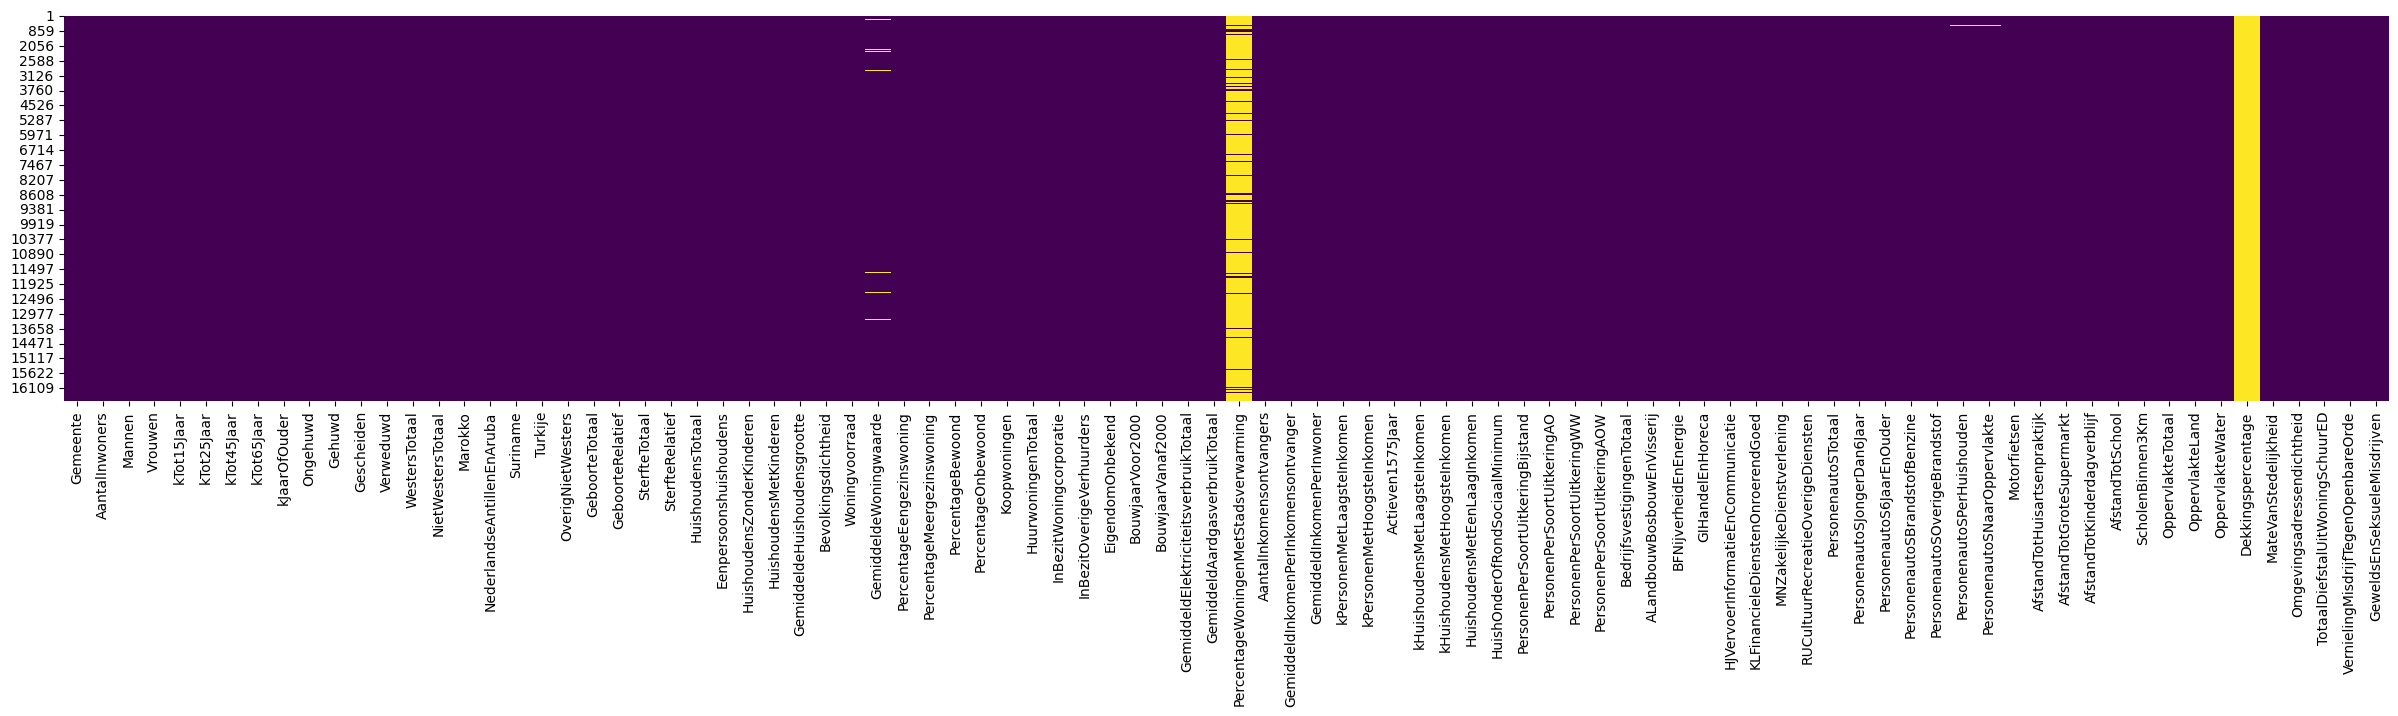

In [53]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_algemeen.isnull(),cbar=False,cmap='viridis')

In [54]:
# Drop columns with only NaN
df_algemeen.drop(columns=['PercentageWoningenMetStadsverwarming', 'Dekkingspercentage'], inplace=True)

# Filling missing data with avg
df_algemeen['GemiddeldeWoningwaarde'].fillna((df_algemeen['GemiddeldeWoningwaarde'].mean()), inplace=True)

Gereed maken df_afstanden

In [55]:
df_afstanden.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9452 entries, 0 to 9451
Columns: 128 entries, ID to AfstandTotBrandweerkazerne_125
dtypes: float64(125), int64(1), object(2)
memory usage: 9.2+ MB


In [56]:
# Checking for possible values
for col in df_afstanden.columns:
    try:
        print('{} : {}'.format(col,df_afstanden[col].unique()))
    except:
        print(col)

ID : [   0    1    2 ... 9449 9450 9451]
RegioS : ['Nederland' 'Noord-Nederland (LD)' 'Oost-Nederland (LD)'
 'West-Nederland (LD)' 'Zuid-Nederland (LD)' 'Groningen (PV)'
 'Fryslân (PV)' 'Drenthe (PV)' 'Overijssel (PV)' 'Flevoland (PV)'
 'Gelderland (PV)' 'Utrecht (PV)' 'Noord-Holland (PV)' 'Zuid-Holland (PV)'
 'Zeeland (PV)' 'Noord-Brabant (PV)' 'Limburg (PV)' 'Oost-Groningen (CR)'
 'Delfzijl en omgeving (CR)' 'Overig Groningen (CR)'
 'Noord-Friesland (CR)' 'Zuidwest-Friesland (CR)'
 'Zuidoost-Friesland (CR)' 'Noord-Drenthe (CR)' 'Zuidoost-Drenthe (CR)'
 'Zuidwest-Drenthe (CR)' 'Noord-Overijssel (CR)'
 'Zuidwest-Overijssel (CR)' 'Twente (CR)' 'Veluwe (CR)' 'Achterhoek (CR)'
 'Arnhem/Nijmegen (CR)' 'Zuidwest-Gelderland (CR)' 'Utrecht (CR)'
 'Kop van Noord-Holland (CR)' 'Alkmaar en omgeving (CR)' 'IJmond (CR)'
 'Agglomeratie Haarlem (CR)' 'Zaanstreek (CR)' 'Groot-Amsterdam (CR)'
 'Het Gooi en Vechtstreek (CR)' 'Agglomeratie Leiden en Bollenstreek (CR)'
 "Agglomeratie 's-Gravenhage (CR)" 

In [57]:
# Rename columns
df_afstanden.rename(columns={'RegioS': 'Gemeente'}, inplace=True)

# Replace values
df_afstanden["Gemeente"] = df_afstanden["Gemeente"].replace("Beek (L.)", "Beek")
df_afstanden["Gemeente"] = df_afstanden["Gemeente"].replace("Stein (L.)", "Stein")

# Separate Beekdaelen into 3 sepereate gemeentes
# beekdaelen = df_afstanden.loc[df_afstanden['Gemeente'] == 'Beekdaelen']

# schinnen_copy = beekdaelen.copy()
# schinnen_copy["Gemeente"] = beekdaelen["Gemeente"].replace("Beekdaelen", "Schinnen")
# 
# nuth_copy = beekdaelen.copy()
# nuth_copy["Gemeente"] = beekdaelen["Gemeente"].replace("Beekdaelen", "Nuth")
# 
# onderbanken_copy = beekdaelen.copy()
# onderbanken_copy["Gemeente"] = beekdaelen["Gemeente"].replace("Beekdaelen", "Onderbanken")

# Concatenate the copies to the original DataFrame
# df_afstanden = pd.concat([df_afstanden, schinnen_copy, nuth_copy, onderbanken_copy], ignore_index=True)

# Dropping useless columns
df_afstanden.drop(columns=['ID'], inplace=True)

<Axes: >

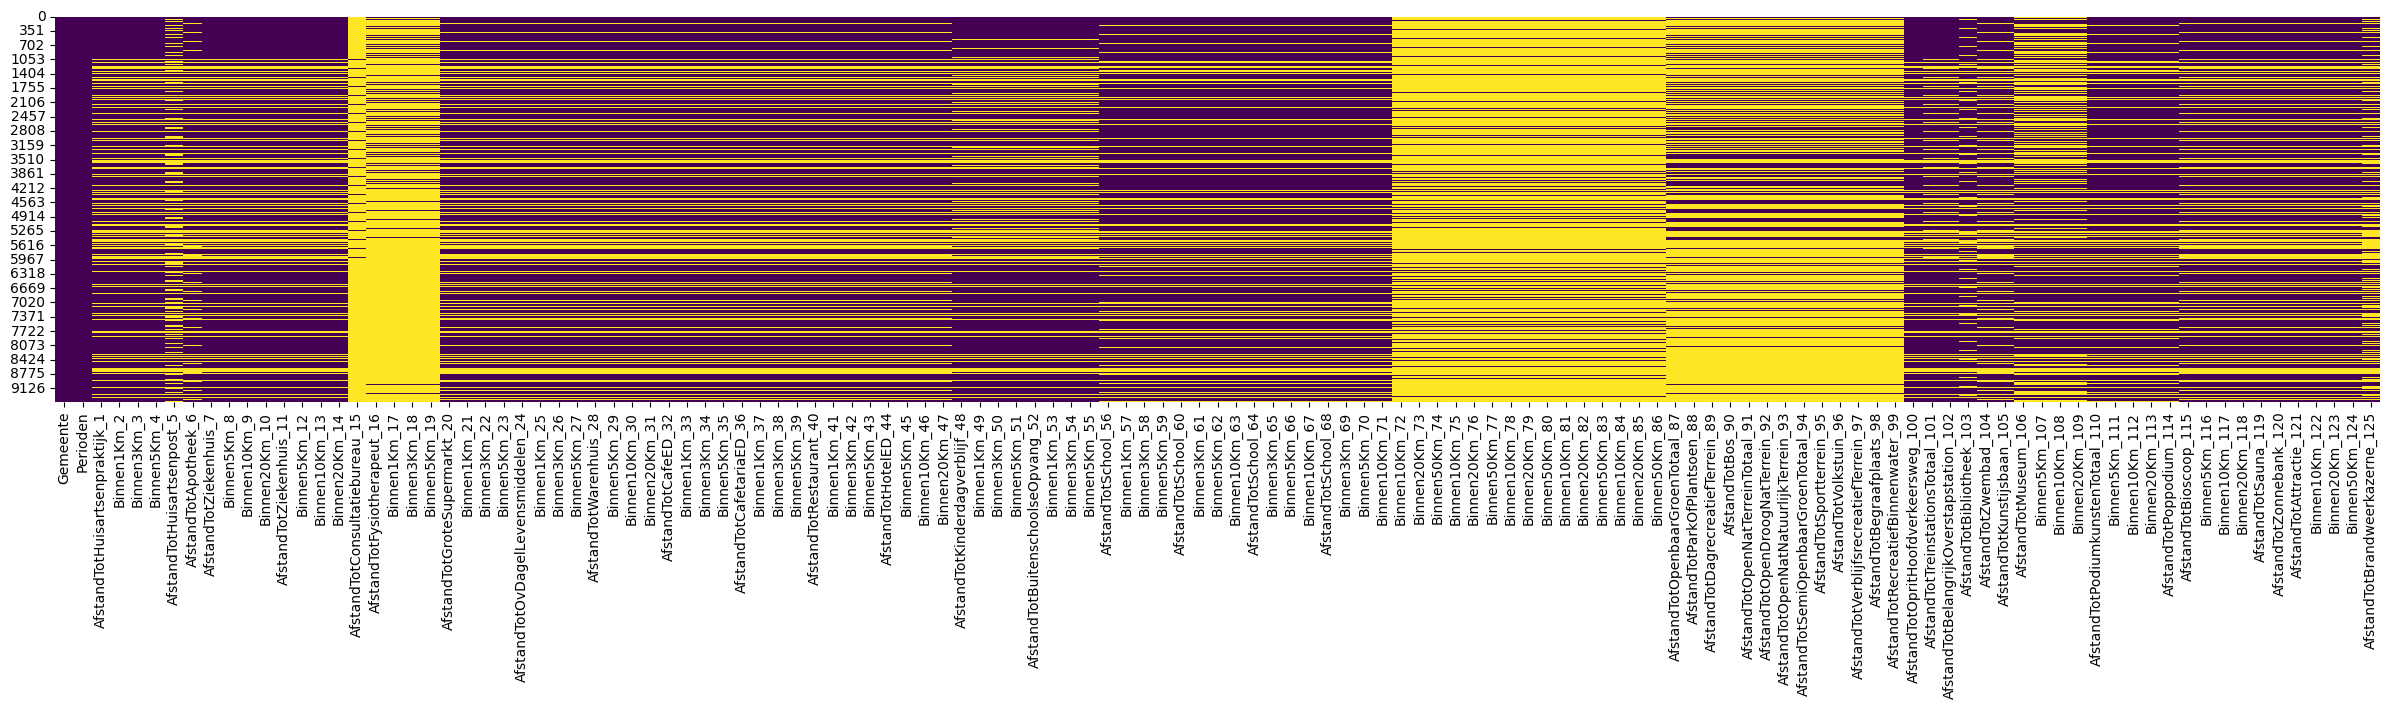

In [58]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_afstanden.isnull(),cbar=False,cmap='viridis')

In [59]:
# Sort the DataFrame by gemeente and perioden columns
df_afstanden = df_afstanden.sort_values(['Gemeente', 'Perioden'])

# Group the DataFrame by gemeente
grouped = df_afstanden.groupby('Gemeente')

# Fill missing values with data from the closest year
df_afstanden = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to ungroup the DataFrame
df_afstanden = df_afstanden.reset_index(drop=True)

In [60]:
# Remove all _number
df_afstanden.columns = df_afstanden.columns.str.replace('_\d+', '', regex=True)

In [61]:
# Drop columns what are already defined in df algemeen
df_afstanden.drop(columns=[
    'AfstandTotHuisartsenpraktijk',
    'AfstandTotGroteSupermarkt',
    'AfstandTotKinderdagverblijf',
    'AfstandTotSchool',
    'AfstandTotSchool',
    'AfstandTotSchool',
    'AfstandTotSchool',
    'AfstandTotZiekenhuis'
], inplace=True)



Gereed maken df_gezondheidsmonitor

In [62]:
df_gezondheidsmonitor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3582 entries, 0 to 3581
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID                                    3582 non-null   int64  
 1   Leeftijd                              3582 non-null   object 
 2   Marges                                3582 non-null   object 
 3   RegioS                                3582 non-null   object 
 4   ErvarenGezondheidGoedZeerGoed_1       3564 non-null   float64
 5   EenOfMeerLangdurigeAandoeningen_2     3561 non-null   float64
 6   EenOfMeerLichamelijkeBeperkingen_3    3561 non-null   float64
 7   BeperkingInHoren_4                    3561 non-null   float64
 8   BeperkingInZien_5                     3561 non-null   float64
 9   BeperkingInBewegen_6                  3561 non-null   float64
 10  Ondergewicht_7                        3552 non-null   float64
 11  NormaalGewicht_8 

In [63]:
# Checking for possible values
for col in df_gezondheidsmonitor.columns:
    try:
        print('{} : {}'.format(col,df_gezondheidsmonitor[col].unique()))
    except:
        print(col)

ID : [   0    1    2 ... 3579 3580 3581]
Leeftijd : ['Totaal' '18 tot 65 jaar' '65 jaar of ouder']
Marges : ['Waarde' 'Ondergrens 95%-interval' 'Bovengrens 95%-interval']
RegioS : ['Nederland' 'Noord-Nederland (LD)' 'Oost-Nederland (LD)'
 'West-Nederland (LD)' 'Zuid-Nederland (LD)' 'Groningen (PV)'
 'Fryslân (PV)' 'Drenthe (PV)' 'Overijssel (PV)' 'Flevoland (PV)'
 'Gelderland (PV)' 'Utrecht (PV)' 'Noord-Holland (PV)' 'Zuid-Holland (PV)'
 'Zeeland (PV)' 'Noord-Brabant (PV)' 'Limburg (PV)' 'Aa en Hunze'
 'Aalsmeer' 'Aalten' 'Achtkarspelen' 'Alblasserdam' 'Albrandswaard'
 'Alkmaar' 'Almelo' 'Almere' 'Alphen aan den Rijn' 'Alphen-Chaam' 'Altena'
 'Ameland' 'Amersfoort' 'Amstelveen' 'Amsterdam' 'Apeldoorn' 'Appingedam'
 'Arnhem' 'Assen' 'Asten' 'Baarle-Nassau' 'Baarn' 'Barendrecht'
 'Barneveld' 'Beek (L.)' 'Beekdaelen' 'Beemster' 'Beesel' 'Berg en Dal'
 'Bergeijk' 'Bergen (L.)' 'Bergen (NH.)' 'Bergen op Zoom' 'Berkelland'
 'Bernheze' 'Best' 'Beuningen' 'Beverwijk' 'De Bilt' 'Bladel' 'Blaric

In [64]:
# Rename columns
df_gezondheidsmonitor.rename(columns={'RegioS': 'Gemeente'}, inplace=True)

# Replace values
df_gezondheidsmonitor["Gemeente"] = df_gezondheidsmonitor["Gemeente"].replace("Beek (L.)", "Beek")
df_gezondheidsmonitor["Gemeente"] = df_gezondheidsmonitor["Gemeente"].replace("Stein (L.)", "Stein")

# Separate Beekdaelen into 3 sepereate gemeentes
beekdaelen = df_gezondheidsmonitor.loc[df_gezondheidsmonitor['Gemeente'] == 'Beekdaelen']

schinnen_copy = beekdaelen.copy()
schinnen_copy["Gemeente"] = beekdaelen["Gemeente"].replace("Beekdaelen", "Schinnen")

nuth_copy = beekdaelen.copy()
nuth_copy["Gemeente"] = beekdaelen["Gemeente"].replace("Beekdaelen", "Nuth")

onderbanken_copy = beekdaelen.copy()
onderbanken_copy["Gemeente"] = beekdaelen["Gemeente"].replace("Beekdaelen", "Onderbanken")

# Concatenate the copies to the original DataFrame
df_gezondheidsmonitor = pd.concat([df_gezondheidsmonitor, schinnen_copy, nuth_copy, onderbanken_copy], ignore_index=True)

# Verkijg alle leeftijds categorieën (aangezien deze niet specifiek genoeg zijn)
df_gezondheidsmonitor = df_gezondheidsmonitor[df_gezondheidsmonitor['Leeftijd'] == 'Totaal']

# Verkijg enkel de marges
df_gezondheidsmonitor = df_gezondheidsmonitor[df_gezondheidsmonitor['Marges'] == 'Waarde']

# Dropping useless columns
df_gezondheidsmonitor.drop(columns=['ID', 'Leeftijd', 'Marges'], inplace=True)

In [65]:
df_gezondheidsmonitor

,Gemeente,ErvarenGezondheidGoedZeerGoed_1,EenOfMeerLangdurigeAandoeningen_2,EenOfMeerLichamelijkeBeperkingen_3,BeperkingInHoren_4,BeperkingInZien_5,BeperkingInBewegen_6,Ondergewicht_7,NormaalGewicht_8,Overgewicht_9,...,ErnstigOvergewichtObesitas_11,VoldoetAanBeweegrichtlijn_12,WekelijksSporter_13,Mantelzorger_14,ZwaarBelasteMantelzorgers_15,UrenMantelzorgPerWeek_16,Rokers_17,VoldoetAanRichtlijnAlcoholgebruik_18,ZwareDrinker_19,OvermatigDrinker_20
0,Nederland,79.1,32.2,14.5,4.4,5.4,9.0,1.7,48.8,49.4,...,14.7,50.4,50.8,13.5,13.5,11.6,16.7,43.4,8.2,6.2
1,Noord-Nederland (LD),79.3,33.2,13.6,3.9,4.6,8.9,1.6,47.0,51.4,...,15.4,51.0,45.6,12.5,11.8,12.4,18.3,42.4,8.4,6.8
2,Oost-Nederland (LD),79.7,32.6,14.2,4.4,5.0,8.6,1.5,47.3,51.2,...,15.4,51.1,49.7,14.7,13.6,11.2,16.9,43.3,8.6,6.3
3,West-Nederland (LD),79.4,31.3,14.1,4.2,5.4,8.9,1.9,50.8,47.4,...,13.8,NaN,NaN,12.7,14.0,12.0,16.5,44.4,7.8,6.0
4,Zuid-Nederland (LD),77.4,33.2,15.9,5.0,5.9,9.9,1.7,46.9,51.5,...,15.7,48.9,51.4,14.7,13.2,11.1,16.1,41.4,8.7,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,GGD Fryslân (GG),80.7,32.9,12.8,3.6,4.4,8.2,1.6,47.4,51.0,...,14.5,53.7,46.1,12.2,10.7,11.5,17.7,41.4,9.1,7.3
397,GGD Zaanstreek/Waterland (GG),78.8,33.4,14.4,3.6,5.9,8.7,1.3,46.5,52.2,...,16.0,46.7,47.5,13.0,16.5,12.8,17.5,42.5,8.1,6.0
3582,Schinnen,73.7,37.2,16.9,5.8,5.6,10.7,1.4,43.0,55.6,...,17.7,42.7,46.5,17.3,13.9,10.9,15.7,43.8,7.1,5.2
3591,Nuth,73.7,37.2,16.9,5.8,5.6,10.7,1.4,43.0,55.6,...,17.7,42.7,46.5,17.3,13.9,10.9,15.7,43.8,7.1,5.2


In [66]:
# Remove all _number
df_gezondheidsmonitor.columns = df_gezondheidsmonitor.columns.str.replace('_\d+', '', regex=True)

Merge dataframes

In [89]:
# Perform the first merge between df1 and df2
df_cbsodata = pd.merge(df_algemeen, df_afstanden, on="Gemeente", how="inner")

# Perform the second merge between the result of the first merge and df3
df_cbsodata = pd.merge(df_cbsodata, df_gezondheidsmonitor, on="Gemeente", how="inner")

In [68]:
df_cbsodata

,Gemeente,AantalInwoners,Mannen,Vrouwen,kTot15Jaar,kTot25Jaar,kTot45Jaar,kTot65Jaar,kJaarOfOuder,Ongehuwd,...,ErnstigOvergewichtObesitas,VoldoetAanBeweegrichtlijn,WekelijksSporter,Mantelzorger,ZwaarBelasteMantelzorgers,UrenMantelzorgPerWeek,Rokers,VoldoetAanRichtlijnAlcoholgebruik,ZwareDrinker,OvermatigDrinker
0,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
1,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
2,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
3,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
4,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5758,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5759,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5760,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5761,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7


<Axes: >

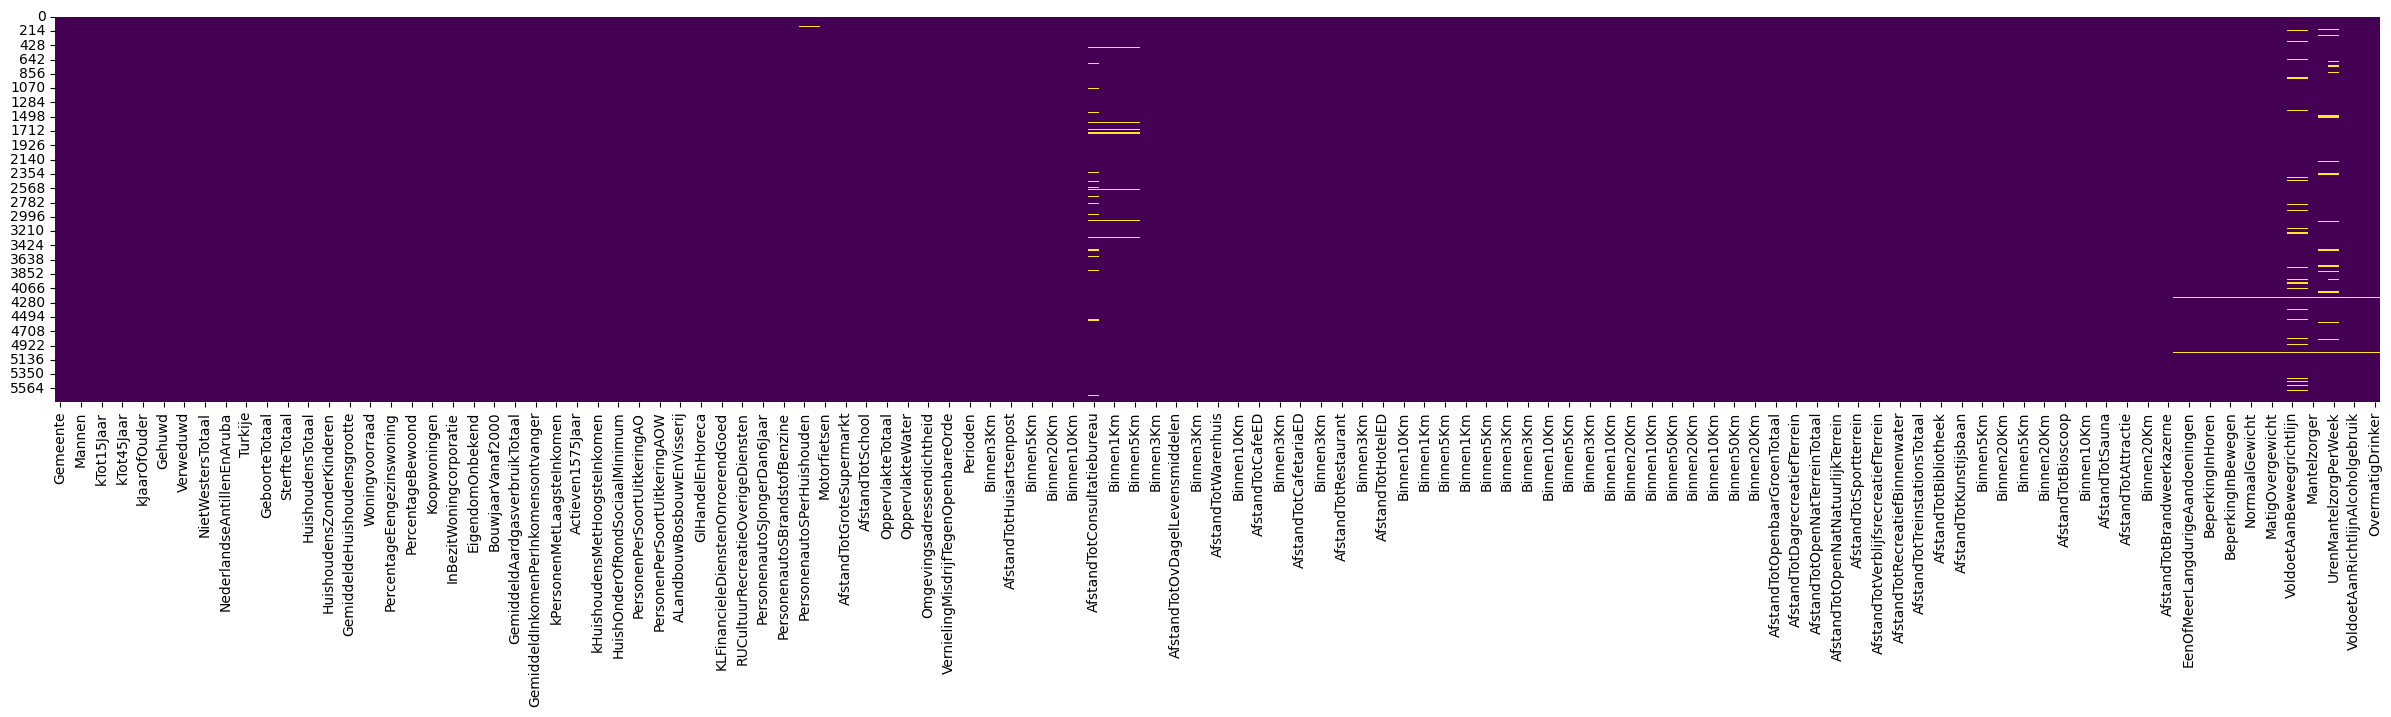

In [69]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_cbsodata.isnull(),cbar=False,cmap='viridis')

In [70]:
df_cbsodata

,Gemeente,AantalInwoners,Mannen,Vrouwen,kTot15Jaar,kTot25Jaar,kTot45Jaar,kTot65Jaar,kJaarOfOuder,Ongehuwd,...,ErnstigOvergewichtObesitas,VoldoetAanBeweegrichtlijn,WekelijksSporter,Mantelzorger,ZwaarBelasteMantelzorgers,UrenMantelzorgPerWeek,Rokers,VoldoetAanRichtlijnAlcoholgebruik,ZwareDrinker,OvermatigDrinker
0,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
1,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
2,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
3,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
4,Aa en Hunze,25286,12603,12683,3572,2558,4383,8467,6306,9951,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5758,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5759,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5760,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5761,Zwolle,125548,61727,63821,22964,15916,35936,31950,18782,65865,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7


In [90]:
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer.fit(df_cbsodata.drop(columns=['Gemeente']))

# transform the dataset
Xtrans = imputer.transform(df_cbsodata.drop(columns=['Gemeente']))

# Convert the transformed array (Xtrans) back to a DataFrame
df_filled = pd.DataFrame(Xtrans, columns=df_cbsodata.drop(columns=['Gemeente']).columns)

# Add the 'Gemeente' column back to the filled DataFrame
df_filled['Gemeente'] = df_cbsodata['Gemeente']

# Reorder the columns to match the original DataFrame
df_cbsodata = df_filled[df_cbsodata.columns]

In [72]:
df_cbsodata

,Gemeente,AantalInwoners,Mannen,Vrouwen,kTot15Jaar,kTot25Jaar,kTot45Jaar,kTot65Jaar,kJaarOfOuder,Ongehuwd,...,ErnstigOvergewichtObesitas,VoldoetAanBeweegrichtlijn,WekelijksSporter,Mantelzorger,ZwaarBelasteMantelzorgers,UrenMantelzorgPerWeek,Rokers,VoldoetAanRichtlijnAlcoholgebruik,ZwareDrinker,OvermatigDrinker
0,Aa en Hunze,25286.0,12603.0,12683.0,3572.0,2558.0,4383.0,8467.0,6306.0,9951.0,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
1,Aa en Hunze,25286.0,12603.0,12683.0,3572.0,2558.0,4383.0,8467.0,6306.0,9951.0,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
2,Aa en Hunze,25286.0,12603.0,12683.0,3572.0,2558.0,4383.0,8467.0,6306.0,9951.0,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
3,Aa en Hunze,25286.0,12603.0,12683.0,3572.0,2558.0,4383.0,8467.0,6306.0,9951.0,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
4,Aa en Hunze,25286.0,12603.0,12683.0,3572.0,2558.0,4383.0,8467.0,6306.0,9951.0,...,14.9,47.3,48.3,16.1,17.1,9.3,14.3,40.6,7.1,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5758,Zwolle,125548.0,61727.0,63821.0,22964.0,15916.0,35936.0,31950.0,18782.0,65865.0,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5759,Zwolle,125548.0,61727.0,63821.0,22964.0,15916.0,35936.0,31950.0,18782.0,65865.0,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5760,Zwolle,125548.0,61727.0,63821.0,22964.0,15916.0,35936.0,31950.0,18782.0,65865.0,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7
5761,Zwolle,125548.0,61727.0,63821.0,22964.0,15916.0,35936.0,31950.0,18782.0,65865.0,...,11.0,54.6,54.4,13.1,12.2,11.3,17.6,38.4,7.5,5.7


<Axes: >

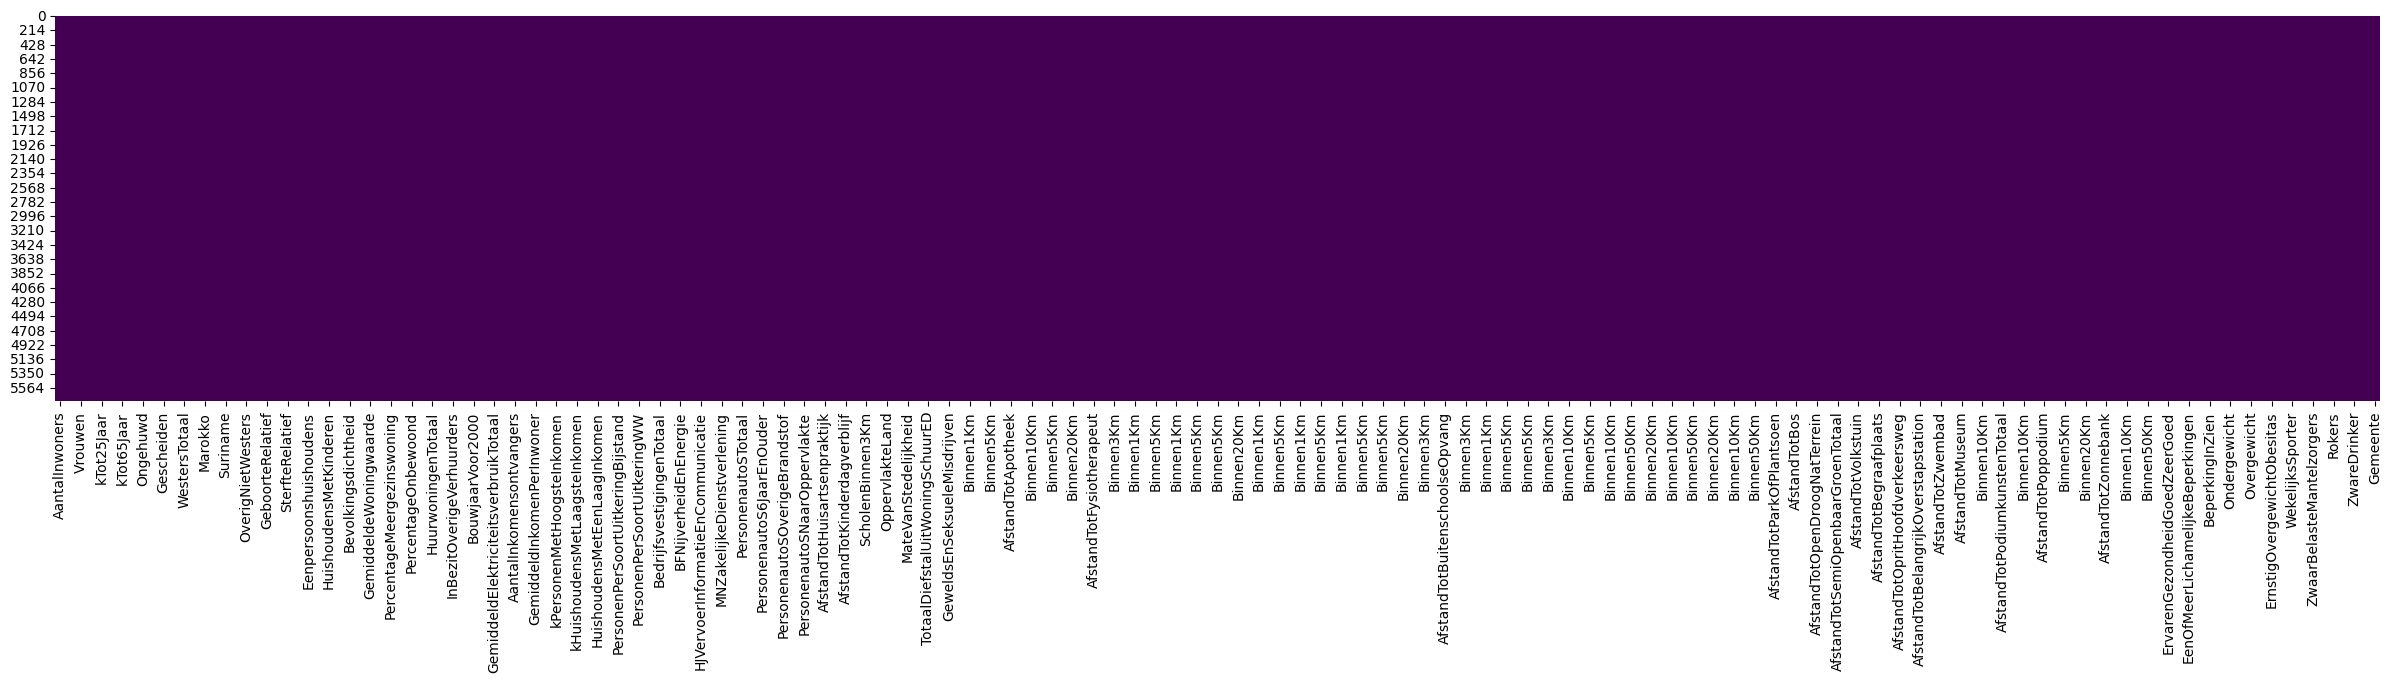

In [73]:
# View a plot with all NaN values Yellow
fig, ax = plt.subplots(figsize=(30, 5))
sns.heatmap(df_filled.isnull(),cbar=False,cmap='viridis')

In [74]:
# Checking for columns values
for col in df_cbsodata.columns:
    try:
        print('{}'.format(col))
    except:
        print(col)

Gemeente
AantalInwoners
Mannen
Vrouwen
kTot15Jaar
kTot25Jaar
kTot45Jaar
kTot65Jaar
kJaarOfOuder
Ongehuwd
Gehuwd
Gescheiden
Verweduwd
WestersTotaal
NietWestersTotaal
Marokko
NederlandseAntillenEnAruba
Suriname
Turkije
OverigNietWesters
GeboorteTotaal
GeboorteRelatief
SterfteTotaal
SterfteRelatief
HuishoudensTotaal
Eenpersoonshuishoudens
HuishoudensZonderKinderen
HuishoudensMetKinderen
GemiddeldeHuishoudensgrootte
Bevolkingsdichtheid
Woningvoorraad
GemiddeldeWoningwaarde
PercentageEengezinswoning
PercentageMeergezinswoning
PercentageBewoond
PercentageOnbewoond
Koopwoningen
HuurwoningenTotaal
InBezitWoningcorporatie
InBezitOverigeVerhuurders
EigendomOnbekend
BouwjaarVoor2000
BouwjaarVanaf2000
GemiddeldElektriciteitsverbruikTotaal
GemiddeldAardgasverbruikTotaal
AantalInkomensontvangers
GemiddeldInkomenPerInkomensontvanger
GemiddeldInkomenPerInwoner
kPersonenMetLaagsteInkomen
kPersonenMetHoogsteInkomen
Actieven1575Jaar
kHuishoudensMetLaagsteInkomen
kHuishoudensMetHoogsteInkomen
HuishoudensM

In [75]:
# Checking for possible values
for col in df_cbsodata.columns:
    try:
        print('{} : {}'.format(col,df_cbsodata[col].unique()))
    except:
        print(col)

Gemeente : ['Aa en Hunze' 'Aalsmeer' 'Aalten' 'Achtkarspelen' 'Alblasserdam'
 'Albrandswaard' 'Alkmaar' 'Almelo' 'Almere' 'Alphen aan den Rijn'
 'Alphen-Chaam' 'Ameland' 'Amersfoort' 'Amstelveen' 'Amsterdam'
 'Apeldoorn' 'Appingedam' 'Arnhem' 'Assen' 'Asten' 'Baarle-Nassau' 'Baarn'
 'Barendrecht' 'Barneveld' 'Beek' 'Beemster' 'Beesel' 'Berg en Dal'
 'Bergeijk' 'Bergen (L.)' 'Bergen (NH.)' 'Bergen op Zoom' 'Berkelland'
 'Bernheze' 'Best' 'Beuningen' 'Beverwijk' 'De Bilt' 'Bladel' 'Blaricum'
 'Bloemendaal' 'Bodegraven-Reeuwijk' 'Boekel' 'Borger-Odoorn' 'Borne'
 'Borsele' 'Boxmeer' 'Boxtel' 'Breda' 'Brielle' 'Bronckhorst' 'Brummen'
 'Brunssum' 'Bunnik' 'Bunschoten' 'Buren' 'Capelle aan den IJssel'
 'Castricum' 'Coevorden' 'Cranendonck' 'Cuijk' 'Culemborg' 'Dalfsen'
 'Dantumadiel' 'Delft' 'Delfzijl' 'Deurne' 'Deventer' 'Diemen'
 'Dinkelland' 'Doesburg' 'Doetinchem' 'Dongen' 'Dordrecht' 'Drechterland'
 'Drimmelen' 'Dronten' 'Druten' 'Duiven' 'Echt-Susteren' 'Edam-Volendam'
 'Ede' 'Eemnes' '

In [92]:
# Replace the exact string '.' with NaN values
df_cbsodata.replace('.', np.nan, inplace=True)

Reduce colums

*Alle kolommen met de naam binnen zijn overbodig aangezien de gemiddelde afstand tot berekend is voor de inwoners. Deze kolommen zijn veel specifieker en het verwijderen van de binnen kolommen voorkomen overbodige informatie die minder contreet is*

In [93]:
# Drop all columns containing the word Binnen 
df_cbsodata = df_cbsodata.filter(regex=r'^(?!.*Binnen).*$', axis=1)

Normalize data

In [94]:
# Select columns with int64 and float64 data types
numeric_columns = df_cbsodata.drop(columns=['Perioden']).select_dtypes(include=['int64', 'float64']).columns

# Normalize data
scaler = StandardScaler()
df_cbsodata[numeric_columns] = pd.DataFrame(scaler.fit_transform(df_cbsodata[numeric_columns]), columns=numeric_columns)

Reduce colums

In [80]:
# Defining the function that you will run later
#https://github.com/K-Ellis/Neural-Network-Classification-and-Unbalanced-Bank-Marketing-Data/issues/1#issue-234132765
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print(variables)
    
    return X[[i for i in variables]]

def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores

In [85]:
# Remaining columns with vif score lower then 5
ListMulticollinearityVIFTestColumns = []
vif_scores(calculate_vif_(df_cbsodata.drop(columns=['Gemeente', 'Perioden']),5))

143


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:   21.2s finished


Thu Jun 29 11:49:23 2023 dropping 'AantalInwoners' at index: 0
142


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 142 out of 142 | elapsed:   20.2s finished


Thu Jun 29 11:49:44 2023 dropping 'Mannen' at index: 0
141


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:   19.7s finished


Thu Jun 29 11:50:04 2023 dropping 'kTot15Jaar' at index: 1
140


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   19.3s finished


Thu Jun 29 11:50:23 2023 dropping 'NietWestersTotaal' at index: 10
139


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:   19.2s finished


Thu Jun 29 11:50:43 2023 dropping 'HuishoudensTotaal' at index: 19
138


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 138 out of 138 | elapsed:   19.8s finished


Thu Jun 29 11:51:03 2023 dropping 'PercentageEengezinswoning' at index: 26
137


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:   19.3s finished


Thu Jun 29 11:51:23 2023 dropping 'PercentageBewoond' at index: 27
136


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:   18.7s finished


Thu Jun 29 11:51:42 2023 dropping 'BouwjaarVoor2000' at index: 33
135


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   18.2s finished


Thu Jun 29 11:52:01 2023 dropping 'OppervlakteTotaal' at index: 70
134


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:   20.6s finished


Thu Jun 29 11:52:22 2023 dropping 'PersonenautoSTotaal' at index: 58
133


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:   17.9s finished


Thu Jun 29 11:52:40 2023 dropping 'PersonenautoSBrandstofBenzine' at index: 60
132


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:   16.5s finished


Thu Jun 29 11:52:57 2023 dropping 'BedrijfsvestigingenTotaal' at index: 50
131


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:   15.9s finished


Thu Jun 29 11:53:13 2023 dropping 'kJaarOfOuder' at index: 4
130


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   15.5s finished


Thu Jun 29 11:53:29 2023 dropping 'Ongehuwd' at index: 4
129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:   21.2s finished


Thu Jun 29 11:53:51 2023 dropping 'AantalInkomensontvangers' at index: 34
128


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   24.3s finished


Thu Jun 29 11:54:15 2023 dropping 'Vrouwen' at index: 0
127


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:   23.7s finished


Thu Jun 29 11:54:39 2023 dropping 'Overgewicht' at index: 115
126


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:   23.5s finished


Thu Jun 29 11:55:03 2023 dropping 'kTot45Jaar' at index: 1
125


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   22.6s finished


Thu Jun 29 11:55:26 2023 dropping 'Woningvoorraad' at index: 20
124


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:   22.4s finished


Thu Jun 29 11:55:49 2023 dropping 'NormaalGewicht' at index: 112
123


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:   22.5s finished


Thu Jun 29 11:56:12 2023 dropping 'HuishoudensMetKinderen' at index: 17
122


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:   21.3s finished


Thu Jun 29 11:56:33 2023 dropping 'Eenpersoonshuishoudens' at index: 15
121


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:   22.2s finished


Thu Jun 29 11:56:56 2023 dropping 'kTot65Jaar' at index: 1
120


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   19.6s finished


Thu Jun 29 11:57:16 2023 dropping 'PersonenPerSoortUitkeringAOW' at index: 40
119


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:   19.2s finished


Thu Jun 29 11:57:35 2023 dropping 'HuishoudensZonderKinderen' at index: 14
118


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 118 out of 118 | elapsed:   19.1s finished


Thu Jun 29 11:57:55 2023 dropping 'Gescheiden' at index: 2
117


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 117 out of 117 | elapsed:   18.2s finished


Thu Jun 29 11:58:13 2023 dropping 'Gehuwd' at index: 1
116


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:   17.9s finished


Thu Jun 29 11:58:31 2023 dropping 'SterfteTotaal' at index: 10
115


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:   17.5s finished


Thu Jun 29 11:58:49 2023 dropping 'MNZakelijkeDienstverlening' at index: 41
114


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:   17.1s finished


Thu Jun 29 11:59:07 2023 dropping 'PersonenautoS6JaarEnOuder' at index: 43
113


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:   16.6s finished


Thu Jun 29 11:59:23 2023 dropping 'GeboorteTotaal' at index: 8
112


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   16.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:   16.1s finished


Thu Jun 29 11:59:40 2023 dropping 'HuurwoningenTotaal' at index: 16
111


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:   15.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:   15.5s finished


Thu Jun 29 11:59:56 2023 dropping 'GIHandelEnHoreca' at index: 36
110


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   15.2s finished


Thu Jun 29 12:00:11 2023 dropping 'HJVervoerInformatieEnCommunicatie' at index: 36
109


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:   15.0s finished


Thu Jun 29 12:00:26 2023 dropping 'PersonenautoSJongerDan6Jaar' at index: 38
108


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   14.4s finished


Thu Jun 29 12:00:41 2023 dropping 'Koopwoningen' at index: 15
107


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:   13.8s finished


Thu Jun 29 12:00:55 2023 dropping 'GemiddeldInkomenPerInwoner' at index: 22
106


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:   13.2s finished


Thu Jun 29 12:01:09 2023 dropping 'PersonenPerSoortUitkeringBijstand' at index: 29
105


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   13.2s finished


Thu Jun 29 12:01:22 2023 dropping 'PersonenPerSoortUitkeringWW' at index: 30
104


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 102 out of 104 | elapsed:   12.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:   12.6s finished


Thu Jun 29 12:01:35 2023 dropping 'OverigNietWesters' at index: 7
103


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 101 out of 103 | elapsed:   12.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:   12.5s finished


Thu Jun 29 12:01:48 2023 dropping 'RUCultuurRecreatieOverigeDiensten' at index: 32
102


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 102 | elapsed:   11.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   12.0s finished


Thu Jun 29 12:02:00 2023 dropping 'kTot25Jaar' at index: 0
101


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  99 out of 101 | elapsed:   12.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   12.5s finished


Thu Jun 29 12:02:13 2023 dropping 'Bevolkingsdichtheid' at index: 9
100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:   12.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished


Thu Jun 29 12:02:26 2023 dropping 'WestersTotaal' at index: 1
99


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  96 out of  99 | elapsed:   10.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   11.0s finished


Thu Jun 29 12:02:37 2023 dropping 'HuishoudensMetEenLaagInkomen' at index: 23
98


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  95 out of  98 | elapsed:   10.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   10.9s finished


Thu Jun 29 12:02:49 2023 dropping 'Verweduwd' at index: 0
97


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  94 out of  97 | elapsed:   10.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   10.1s finished


Thu Jun 29 12:02:59 2023 dropping 'kHuishoudensMetHoogsteInkomen' at index: 21
96


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  93 out of  96 | elapsed:    9.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    9.2s finished


Thu Jun 29 12:03:08 2023 dropping 'kHuishoudensMetLaagsteInkomen' at index: 20
95


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  92 out of  95 | elapsed:    8.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    8.9s finished


Thu Jun 29 12:03:18 2023 dropping 'Marokko' at index: 0
94


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  90 out of  94 | elapsed:    8.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    8.9s finished


Thu Jun 29 12:03:27 2023 dropping 'PersonenPerSoortUitkeringAO' at index: 20
93


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  89 out of  93 | elapsed:    8.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    8.2s finished


Thu Jun 29 12:03:35 2023 dropping 'EenOfMeerLichamelijkeBeperkingen' at index: 77
92


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  88 out of  92 | elapsed:    7.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    7.7s finished


Thu Jun 29 12:03:43 2023 dropping 'BFNijverheidEnEnergie' at index: 21
91


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  87 out of  91 | elapsed:    7.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    7.7s finished


Thu Jun 29 12:03:51 2023 dropping 'Omgevingsadressendichtheid' at index: 33
90


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  86 out of  90 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.3s finished


Thu Jun 29 12:03:59 2023 dropping 'Suriname' at index: 1
89


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  84 out of  89 | elapsed:    6.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    7.0s finished


Thu Jun 29 12:04:06 2023 dropping 'GemiddeldInkomenPerInkomensontvanger' at index: 14
88


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  83 out of  88 | elapsed:    6.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:    6.8s finished


Thu Jun 29 12:04:13 2023 dropping 'Turkije' at index: 1
87


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  82 out of  87 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    6.5s finished


Thu Jun 29 12:04:20 2023 dropping 'Motorfietsen' at index: 22
86


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  81 out of  86 | elapsed:    6.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    6.6s finished


Thu Jun 29 12:04:27 2023 dropping 'kPersonenMetHoogsteInkomen' at index: 14
85


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  80 out of  85 | elapsed:    6.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    6.1s finished


Thu Jun 29 12:04:33 2023 dropping 'HuishOnderOfRondSociaalMinimum' at index: 15
84


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  78 out of  84 | elapsed:    5.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    5.8s finished


Thu Jun 29 12:04:39 2023 dropping 'AfstandTotParkOfPlantsoen' at index: 42
83


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  77 out of  83 | elapsed:    6.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:    6.4s finished


Thu Jun 29 12:04:46 2023 dropping 'PercentageMeergezinswoning' at index: 5
82


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  76 out of  82 | elapsed:    6.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:    6.8s finished


Thu Jun 29 12:04:53 2023 dropping 'GemiddeldeHuishoudensgrootte' at index: 3
81


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed:    7.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    7.3s finished


Thu Jun 29 12:05:01 2023 dropping 'GemiddeldElektriciteitsverbruikTotaal' at index: 9
80


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:    5.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.6s finished


Thu Jun 29 12:05:07 2023 dropping 'MateVanStedelijkheid' at index: 23
79


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:    5.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:    5.2s finished


Thu Jun 29 12:05:12 2023 dropping 'Actieven1575Jaar' at index: 11
78


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:    4.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Thu Jun 29 12:05:17 2023 dropping 'AfstandTotOpritHoofdverkeersweg' at index: 47
77


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:    4.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    4.8s finished


Thu Jun 29 12:05:22 2023 dropping 'OppervlakteLand' at index: 20
76


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:    4.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Thu Jun 29 12:05:27 2023 dropping 'WekelijksSporter' at index: 68
75


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:    4.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Thu Jun 29 12:05:32 2023 dropping 'ZwareDrinker' at index: 73
74


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  66 out of  74 | elapsed:    4.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Thu Jun 29 12:05:37 2023 dropping 'BeperkingInBewegen' at index: 63
73


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  65 out of  73 | elapsed:    4.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Thu Jun 29 12:05:42 2023 dropping 'AfstandTotGroteSupermarkt' at index: 17
72


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  64 out of  72 | elapsed:    3.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Thu Jun 29 12:05:46 2023 dropping 'GemiddeldAardgasverbruikTotaal' at index: 9
71


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  63 out of  71 | elapsed:    3.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    3.9s finished


Thu Jun 29 12:05:50 2023 dropping 'AfstandTotFysiotherapeut' at index: 25
70


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 out of  70 | elapsed:    3.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    3.6s finished


Remaining variables:
['NederlandseAntillenEnAruba', 'GeboorteRelatief', 'SterfteRelatief', 'GemiddeldeWoningwaarde', 'PercentageOnbewoond', 'InBezitWoningcorporatie', 'InBezitOverigeVerhuurders', 'EigendomOnbekend', 'BouwjaarVanaf2000', 'kPersonenMetLaagsteInkomen', 'ALandbouwBosbouwEnVisserij', 'KLFinancieleDienstenOnroerendGoed', 'PersonenautoSOverigeBrandstof', 'PersonenautoSPerHuishouden', 'PersonenautoSNaarOppervlakte', 'AfstandTotHuisartsenpraktijk', 'AfstandTotKinderdagverblijf', 'AfstandTotSchool', 'OppervlakteWater', 'TotaalDiefstalUitWoningSchuurED', 'VernielingMisdrijfTegenOpenbareOrde', 'GeweldsEnSeksueleMisdrijven', 'AfstandTotHuisartsenpost', 'AfstandTotApotheek', 'AfstandTotConsultatiebureau', 'AfstandTotOvDagelLevensmiddelen', 'AfstandTotWarenhuis', 'AfstandTotCafeED', 'AfstandTotCafetariaED', 'AfstandTotRestaurant', 'AfstandTotHotelED', 'AfstandTotBuitenschoolseOpvang', 'AfstandTotOpenbaarGroenTotaal', 'AfstandTotDagrecreatiefTerrein', 'AfstandTotBos', 'AfstandTotOpenN

,Independent Features,VIF Scores
0,NederlandseAntillenEnAruba,2.630417
1,GeboorteRelatief,2.553064
2,SterfteRelatief,2.854589
3,GemiddeldeWoningwaarde,4.108775
4,PercentageOnbewoond,4.303572
...,...,...
65,ZwaarBelasteMantelzorgers,1.608100
66,UrenMantelzorgPerWeek,1.573638
67,Rokers,3.438312
68,VoldoetAanRichtlijnAlcoholgebruik,3.585035


Only select usefull columns

In [95]:
df_cbsodata = df_cbsodata[['Gemeente', 'Perioden', 'NederlandseAntillenEnAruba', 'GeboorteRelatief', 'SterfteRelatief', 'GemiddeldeWoningwaarde', 'PercentageOnbewoond', 'InBezitWoningcorporatie', 'InBezitOverigeVerhuurders', 'EigendomOnbekend', 'BouwjaarVanaf2000', 'kPersonenMetLaagsteInkomen', 'ALandbouwBosbouwEnVisserij', 'KLFinancieleDienstenOnroerendGoed', 'PersonenautoSOverigeBrandstof', 'PersonenautoSPerHuishouden', 'PersonenautoSNaarOppervlakte', 'AfstandTotHuisartsenpraktijk', 'AfstandTotKinderdagverblijf', 'AfstandTotSchool', 'OppervlakteWater', 'TotaalDiefstalUitWoningSchuurED', 'VernielingMisdrijfTegenOpenbareOrde', 'GeweldsEnSeksueleMisdrijven', 'AfstandTotHuisartsenpost', 'AfstandTotApotheek', 'AfstandTotConsultatiebureau', 'AfstandTotOvDagelLevensmiddelen', 'AfstandTotWarenhuis', 'AfstandTotCafeED', 'AfstandTotCafetariaED', 'AfstandTotRestaurant', 'AfstandTotHotelED', 'AfstandTotBuitenschoolseOpvang', 'AfstandTotOpenbaarGroenTotaal', 'AfstandTotDagrecreatiefTerrein', 'AfstandTotBos', 'AfstandTotOpenNatTerreinTotaal', 'AfstandTotOpenDroogNatTerrein', 'AfstandTotOpenNatNatuurlijkTerrein', 'AfstandTotSemiOpenbaarGroenTotaal', 'AfstandTotSportterrein', 'AfstandTotVolkstuin', 'AfstandTotVerblijfsrecreatiefTerrein', 'AfstandTotBegraafplaats', 'AfstandTotTreinstationsTotaal', 'AfstandTotBelangrijkOverstapstation', 'AfstandTotBibliotheek', 'AfstandTotZwembad', 'AfstandTotKunstijsbaan', 'AfstandTotMuseum', 'AfstandTotPodiumkunstenTotaal', 'AfstandTotPoppodium', 'AfstandTotBioscoop', 'AfstandTotSauna', 'AfstandTotZonnebank', 'AfstandTotAttractie', 'AfstandTotBrandweerkazerne', 'ErvarenGezondheidGoedZeerGoed', 'EenOfMeerLangdurigeAandoeningen', 'BeperkingInHoren', 'BeperkingInZien', 'Ondergewicht', 'MatigOvergewicht', 'ErnstigOvergewichtObesitas', 'VoldoetAanBeweegrichtlijn', 'Mantelzorger', 'ZwaarBelasteMantelzorgers', 'UrenMantelzorgPerWeek', 'Rokers', 'VoldoetAanRichtlijnAlcoholgebruik', 'OvermatigDrinker']]

Export data

In [97]:
df_cbsodata.to_csv('cbsdata_prep.csv', index=False)